In [1]:
import sys
import copy
sys.path.insert(0, "..")
from classes.calculators.lennardjones import LennardJones
from classes.atoms import Atom_Collection, Atom
from classes.optimizers.random_struct_search import Random_Searcher
from classes.optimizers.md_simulator import MD_Simulator
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
plt.rc('animation', html='jshtml')

In [2]:
frozens = [True for i in range(5)] + [False for i in range(2)]
colors = ["C1" for i in range(5)] + ["C0" for i in range(2)]
poss = [np.array([-2.0+i, 0.0]) for i in range(5)] + [np.array([-0.5,1.0]), np.array([0.5,1.0])]

atom_list = []
for color, frozen, pos in zip(colors, frozens, poss):
    atom = Atom(position=pos, color=color, frozen=frozen, size=50)
    atom_list.append(atom)
atom_col = Atom_Collection(atomlist=atom_list)
atom_col.calculator = LennardJones()
#print(atom_col.get_forces())
rand_searcher = Random_Searcher(atom_col=atom_col, step_size=0.1)
atom_rel = rand_searcher.line_search(atom_col=atom_col, fmax=0.05)
atom_rel.rattle_atoms(delta=0.05)

In [3]:
md_simulator = MD_Simulator()
md_atoms = md_simulator.run_N2_integration(atom_col=atom_rel, N_steps=100, t_init=0.0)
positions = np.array([md_atom.get_positions() for md_atom in md_atoms])
velocities = np.array([md_atom.get_velocities() for md_atom in md_atoms])
potential_energies = []
kinetic_energies = []
total_energies = []
init_pos = atom_rel.get_positions()
for vel, pos in zip(velocities, positions):
    pot_e = atom_rel.get_potential_energy()
    kin_e = atom_rel.get_kinetic_energy()
    potential_energies.append(pot_e)
    kinetic_energies.append(kin_e)
    total_energies.append(pot_e+kin_e)
    atom_rel.set_positions(pos)
    atom_rel.set_velocities(vel)
atom_rel.set_positions(init_pos)

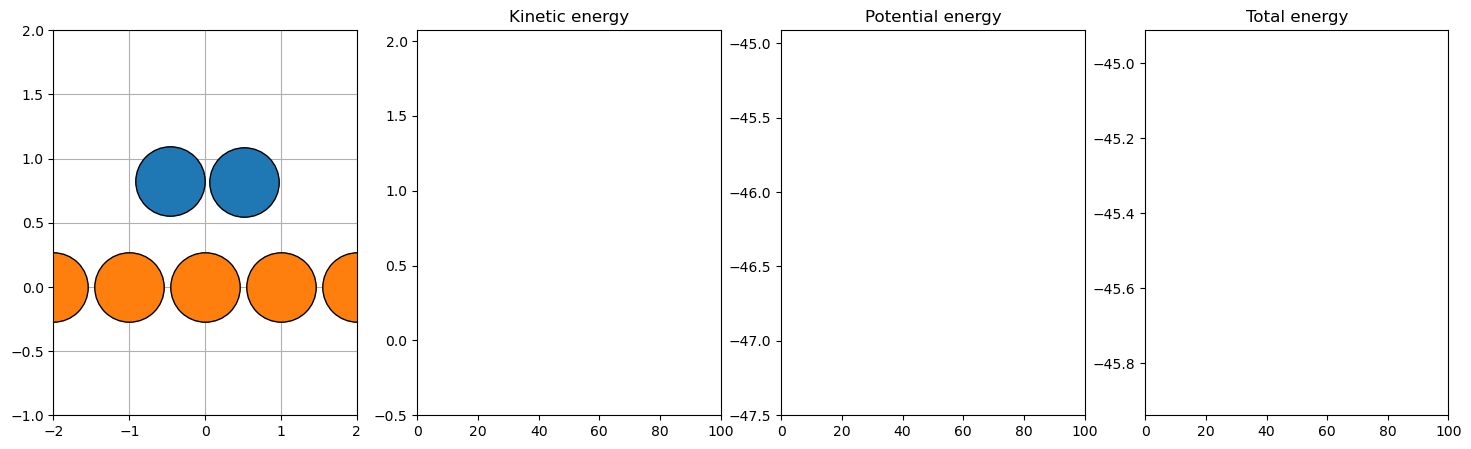

In [4]:
fig, axs = plt.subplots(1,4, figsize=(18,5))
axs[0].set_xlim([-2,2])
axs[0].set_ylim([-1,2])
axs[1].set_ylim([np.min(kinetic_energies)-0.5,np.max(kinetic_energies)+0.5])
axs[2].set_ylim([np.min(potential_energies)-0.5,np.max(potential_energies)+0.5])
axs[3].set_ylim([np.min(total_energies)-0.5,np.max(total_energies)+0.5])
axs[1].set_title("Kinetic energy")
axs[2].set_title("Potential energy")
axs[3].set_title("Total energy")
for i in [1,2,3]:
    axs[i].set_xlim([0,100])

atom_rel.plot(ax=axs[0])
axs[0].grid()

def update(i):
    pos = positions[i]
    atom_rel.set_positions(pos)
    plot_elem = atom_rel.plot(ax=axs[0])
    init_pot = potential_energies[i]
    final_pot = potential_energies[i+1]
    init_kin = kinetic_energies[i]
    final_kin = kinetic_energies[i+1]
    tot_init = total_energies[i]
    tot_final = total_energies[i+1]
    axs[1].plot([i,i+1], [init_kin, final_kin], c="r")
    axs[2].plot([i,i+1], [init_pot, final_pot], c="blue")
    axs[3].plot([i,i+1], [tot_init, tot_final], c="green")
    return plot_elem

In [5]:
N = 90
anim = animation.FuncAnimation(fig,
                               update,
                               frames=N,
                               interval=75,
                               blit=True)
anim